# Dogs vs. cats classification
IFT6135 - Winter 2019

Assigment 1 - Problem 3

Authors: <br>
Stephan Tran <br>
Oussema Keskes <br>
Stefan Wapnick <br>
Mohamed Amine <br>

Inspired by the IFT6135-H19 PyTorch Tutorial

## Importing libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd

## Defining paremeters and variables

In [2]:
RUN_LOCAL = True
VALID_RATIO = 0.2
TRAIN_RATIO = 1.0 - VALID_RATIO
LEARNING_RATE = 0.00001
BATCH_SIZE = 64
MAX_EPOCH = 150

SAVE_MODEL = True  # Save model after each epoch
LOAD_MODEL = False # Skip training phase

if RUN_LOCAL:
    TRAIN_IMG_DIR ='trainset/trainset'
    TEST_IMG_DIR = 'testset/'
else:
    # Kaggle directory
    TRAIN_IMG_DIR ='../input/trainset/trainset'
    TEST_IMG_DIR = '../input/testset'

cuda_available = torch.cuda.is_available()
print(cuda_available)

True



## Importing datasets and preprocessing
1. Load training and testing images
2. Data augmentation: the dataset size will be 5 times larger <br>
    a) Horizontal flipping <br>
    b) Vertical flipping <br>
    c) Rotation <br>
    d) Random combination of all of the above <br>
3. Transform images into tensor so they could be processed
4. Split dataset into training and validation set

In [3]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# Apply a combination of transforms on all images - 0.5 probability on horizontal and vertical flip
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

image_transform_test = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = datasets.ImageFolder(root=TRAIN_IMG_DIR, transform=image_transform)

dataset_size = len(train_dataset)
train_size = int(TRAIN_RATIO*dataset_size)
valid_size = dataset_size-train_size

# Dataset splitting (validation - training)
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])


trainset_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True,
                                             num_workers=4)

validset_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True,
                                             num_workers=4)


test_dataset = ImageFolderWithPaths(root=TEST_IMG_DIR, transform=image_transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                              num_workers=4)


# Showing some samples of the training set

In [4]:
def imshow(img):
    x, y = img
    x = x.numpy().transpose((1, 2, 0))
    print(x.shape)
    plt.imshow(x)
    if y == 0:
        print('Meow!')
    else:
        print('Barf!')

# plt.figure()  
# plt.subplot(1,2,1)
# imshow(train_dataset[10231])
# plt.subplot(1,2,2)
# imshow(valid_dataset[500])

## Defining CNN architecture

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            # Layer 1: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4: Convolution - ReLU - Max pooling
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
                     
        )        
        # Layer 4: Fully connected
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        
    def forward(self, x):
        temp = self.conv(x)
        temp = temp.view(-1,256*4*4)
        temp = F.relu(self.fc1(temp))
        temp = F.relu(self.fc2(temp))
        temp = F.relu(self.fc3(temp))
        temp = torch.sigmoid(temp)
        return temp
    
cnn = Classifier()
if cuda_available:
    cnn = cnn.cuda()

optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

# Classifier training and validation

In [6]:
best_epoch = 0
best_acc = 0
log_train_loss = []
log_train_acc = []
log_valid_loss = []
log_valid_acc = []
    
for epoch in range(MAX_EPOCH):
    
    losses = []

    total = 0
    correct = 0
    
    ##### TRAINING PHASE ####
    # Set the model in training mode  
    for batch_idx, (inputs, labels) in enumerate(trainset_loader):
        
        # Data conversion to float and cuda
        labels_flt = torch.tensor(labels, dtype=torch.float)
        if cuda_available:
            inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()
            
        # Compute forward phase
        outputs = cnn(inputs).squeeze()
        
        # Compute training loss (Binary Cross Entropy)
        loss = criterion(outputs, labels_flt)
        losses.append(loss.data.item())
        
        # Prediction: since the output is between 0 and 1 du to sigmoid activation function, the
        # prediction value will be 0 when the output is [0,0.5] and 1 when it is ]0.5,1]
        predicted = outputs > 0.5
        if cuda_available:
            predicted = torch.tensor(predicted, dtype=torch.long).cuda()
        else:
            predicted = torch.tensor(predicted, dtype=torch.long)
        
        # Compute training accuracy
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_acc = 100*correct/total
        
        # Backward propagation
        loss.backward()
        optimizer.step()
   
    # Log the training loss and accuracy with respect to the epoch number
    log_train_loss.append([epoch,np.mean(losses)])
    log_train_acc.append([epoch,train_acc])
    
    # Save model into a file for later use
    if SAVE_MODEL:
        torch.save(cnn.state_dict(), "CNN{0:03d}.pwf".format(epoch)) 
    
    
    ##### VALIDATION PHASE ####
    total = 0
    correct = 0    

    # Set the model in evaluation mode
    with torch.no_grad():    
        for batch_idx, (inputs, labels) in enumerate(validset_loader):
            # Data conversion to float and cuda
            labels_flt = torch.tensor(labels, dtype=torch.float)
            if cuda_available:
                inputs, labels_flt, labels = inputs.cuda(), labels_flt.cuda(), labels.cuda()

            # Compute forward phase
            outputs = cnn(inputs).squeeze()   

            # Compute validation loss (Binary Cross Entropy)
            loss = criterion(outputs, labels_flt)
            losses.append(loss.data.item())        

            # Prediction
            predicted = outputs > 0.5
            predicted = torch.tensor(predicted, dtype=torch.long).cuda()

            # Compute training accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            valid_acc = 100*correct/total
        
    # Log the training loss and accuracy with respect to the epoch number
    log_valid_loss.append([epoch,np.mean(losses)])
    log_valid_acc.append([epoch,valid_acc])
    
    if valid_acc > best_acc:
        best_epoch = epoch
        best_acc = valid_acc      
    print('Epoch : %d Test Acc : %.3f Best epoch: %d Best acc: %.3f' % (epoch, valid_acc , best_epoch, best_acc))
    print('------------------------------------------------------------------------------------')

    
log_train_loss = np.swapaxes(np.asarray(log_train_loss),0,1)
log_train_acc = np.swapaxes(np.asarray(log_train_acc),0,1)
log_valid_loss = np.swapaxes(np.asarray(log_valid_loss),0,1)
log_valid_acc = np.swapaxes(np.asarray(log_valid_acc),0,1)

/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: To copy construct from a tensor, it is recommen

Epoch : 0 Test Acc : 49.225 Best epoch: 0 Best acc: 49.225
------------------------------------------------------------------------------------
Epoch : 1 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 2 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 3 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 4 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 5 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 6 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
-----------------------------------------------------------------------------

Epoch : 57 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 58 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 59 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 60 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 61 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 62 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 63 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
----------------------------------------------------------------------

Epoch : 114 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 115 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 116 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 117 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 118 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 119 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
------------------------------------------------------------------------------------
Epoch : 120 Test Acc : 50.775 Best epoch: 1 Best acc: 50.775
---------------------------------------------------------------

## Plot training and validation loss/accuracy

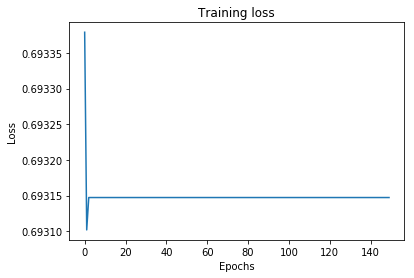

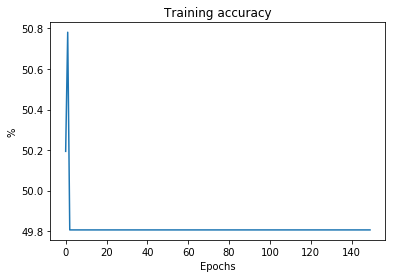

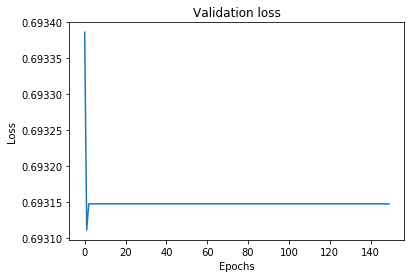

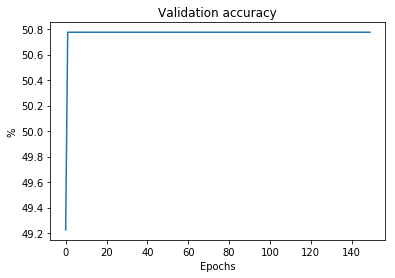

In [7]:
plt.figure(1)
plt.plot(log_train_loss[0], log_train_loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')

plt.figure(2)
plt.plot(log_train_acc[0], log_train_acc[1])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title('Training accuracy')

plt.figure(3)
plt.plot(log_valid_loss[0], log_valid_loss[1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')

plt.figure(4)
plt.plot(log_valid_acc[0], log_valid_acc[1])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.title('Validation accuracy')

plt.show()


## Predicting test dataset

In [8]:
header = ['id', 'label']
prediction = []

with torch.no_grad(): 
    for batch_idx, (inputs, labels, paths) in enumerate(test_loader):
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()   
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = outputs > 0.5
        predicted = torch.tensor(predicted, dtype=torch.long).cuda()    

        filename = os.path.basename(paths[0])
        filename = os.path.splitext(filename)[0]

        if predicted == 0:
            data_out = [filename, 'Cat']
        else:
            data_out = [filename, 'Dog']
        prediction.append(data_out)

# # Write prediction to file    
# with open('submission.csv', 'wt', newline='') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerow(i for i in header)
#     writer.writerows(prediction)
# csvFile.close()

image_name = np.asarray(prediction)[:,0]
label = np.asarray(prediction)[:,1]
submission = pd.DataFrame({ 'id': image_name, 'label': label })
submission.to_csv("my_submission.csv", index=False)
    

/home/stetran/.conda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [9]:
image_name = np.asarray(prediction)[:,0]
label = np.asarray(prediction)[:,1]
submission = pd.DataFrame({ 'id': image_name, 'label': label })
submission.to_csv("my_submission.csv", index=False)